In [44]:
import sys
sys.path.append("..")

from core import coeffs, intersection_points, compute_bounds, sT, compute_bounds_under_planet
from jax import config
config.update("jax_enable_x64", True)

from jaxoplanet.light_curves import LimbDarkLightCurve
from jaxoplanet import light_curves, orbits

import numpy as np
import jax.numpy as jnp
from scipy.integrate import quad
from scipy.special import binom, roots_legendre
import matplotlib.pyplot as plt
%matplotlib inline

# Creating an oblate planet light curve using jax0planet

In this notebook, I will start with some fiducual orbital and planet parameters for an oblate planet transiting a circular star with limb darkening. The goal will be to produce a light curve of the transit of this planet and compare it to a circular planet.  

Remember that in the notebook BruteForceVsNumerical.ipynb, we compared a brute force solution vector $\mathbf{s}^\mathrm{T}$ with the numerical solution using Green's theorem. In the starry formalism, this just means that if we have a limb darkened star parametrized using spherical harmonics as the vector $\mathbf{y}$, we only need to transform to Green's basis using the change of basis matrix $\mathbf{A}$ before dotting into $\mathbf{s}^\mathrm{T}$ to get a flux value. In practice, jaxoplanet already has a function to transform limb darkening coefficients directly to Green's basis, bypassing the need to use spherical harmonics as an intermediate.

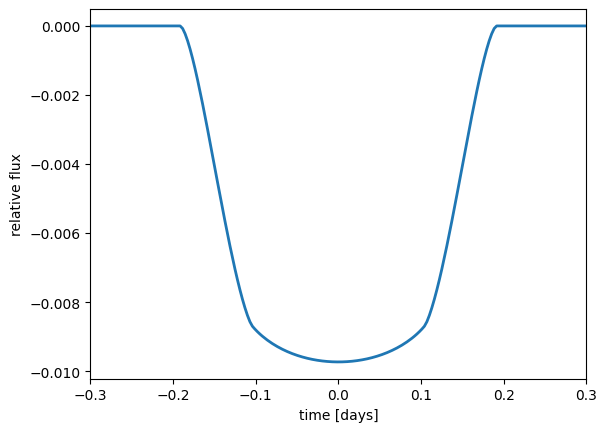

In [45]:
#Fiducial planet parameters:
params = {'period':300.456,
          'radius':0.1,
          'u':jnp.array([0.3,0.2]),
          'b':1.0,
          'bo':0.8,
}
# The light curve calculation requires an orbit

orbit = orbits.KeplerianOrbit.init(period=params['period'], radius=params['radius'], impact_param=params['bo'])

# Compute a limb-darkened light curve using starry
t = jnp.linspace(-0.3, 0.3, 200)

lc = LimbDarkLightCurve(params['u']).light_curve(orbit, t=t)

plt.plot(t, lc[0], color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

In [46]:
def greens_basis_transform(u):
    
    """ Returns the star's flux in Green's basis
    given quadratic limb darkening coefficients"""
    assert u.shape[0]==2
    g = jnp.zeros(9)
    g = g.at[0].set(1-u[0]-2*u[1])
    g = g.at[2].set(u[0] + 2*u[1])
    g = g.at[4].set(u[1]/3)
    g = g.at[8].set(u[1])
    return g
    

Get the position of the planet over time:

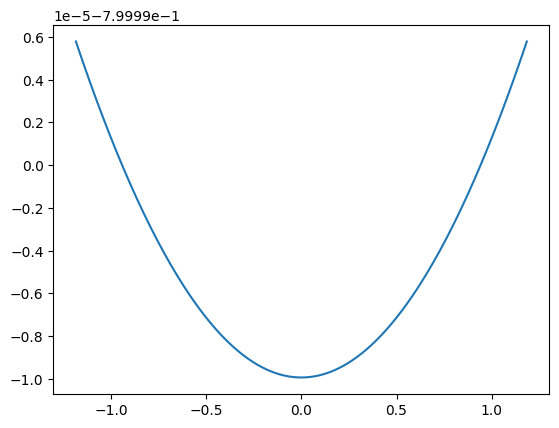

In [48]:
xo, yo = orbit.relative_position(t)[0][0],orbit.relative_position(t)[1][0]
plt.plot(xo,yo)

In [49]:
xis, phis = [],[]
for x, y in zip(xo, yo):
    xis.append(compute_bounds(params['b'],x,y,params['radius'])[0])
    phis.append(compute_bounds(params['b'],x,y,params['radius'])[1])

Now do the integral for a circular planet and compare to jaxoplanet. Keep in mind, we are doing the numerical integral in an extremely inefficient way by manually iterating through the lightcurve and performing the numerical integral using scipy.integrate.quad. The next step will be to jaxify this process. 

In [51]:
from tqdm.notebook import tqdm
fluxes = np.zeros(len(t))
for i, (xi, phi, x, y) in enumerate(tqdm(zip(xis, phis, xo, yo))):
    g = greens_basis_transform(params['u'])
    sT_num = np.zeros(len(g))
    for n in range(len(g)):
        if g[n]!=0:
            sT_num[n] = sT(phi, xi,params['b'],x,y,params['radius'], n=n)
    fluxes[i] = sT_num@g
    

0it [00:00, ?it/s]

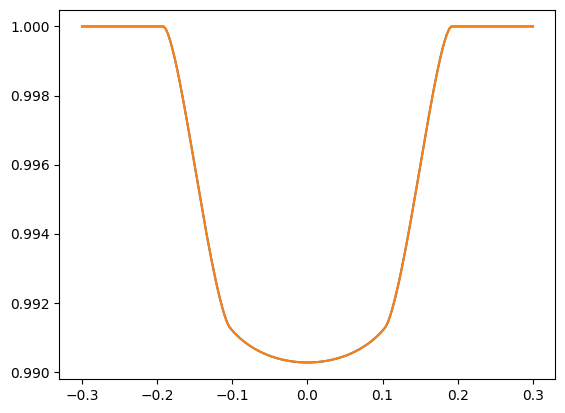

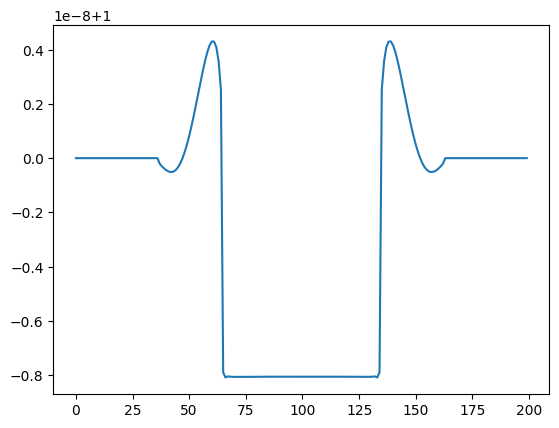

In [55]:
plt.plot((fluxes/fluxes[0])/(lc[0]+1))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

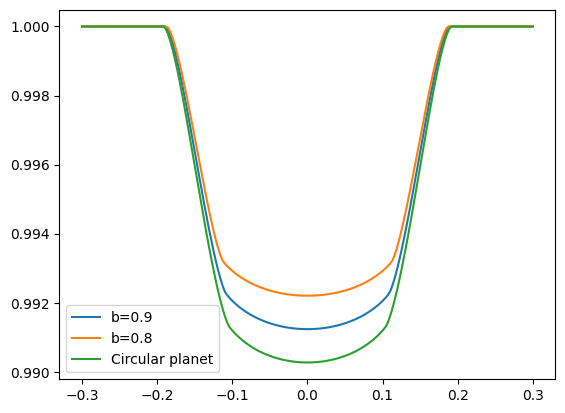

In [62]:
for b in [0.9,0.8]:
    params['b'] = b
    
    xis, phis = [],[]
    for x, y in zip(xo, yo):
        xis.append(compute_bounds(params['b'],x,y,params['radius'])[0])
        phis.append(compute_bounds(params['b'],x,y,params['radius'])[1])
        
    from tqdm.notebook import tqdm
    fluxes = np.zeros(len(t))
    for i, (xi, phi, x, y) in enumerate(tqdm(zip(xis, phis, xo, yo))):
        g = greens_basis_transform(params['u'])
        sT_num = np.zeros(len(g))
        for n in range(len(g)):
            if g[n]!=0:
                sT_num[n] = sT(phi, xi,params['b'],x,y,params['radius'], n=n)
        fluxes[i] = sT_num@g
    plt.plot(t, fluxes/fluxes[0],label='b='+str(b))
plt.plot(t,lc[0]+1,label='Circular planet')
plt.legend()